In [40]:
#Simulation d'une particule dans un potentiel  (Equation de Schrödinger indépendante du temps)

In [41]:
# importation des librairies utiles au programme
import math
import scipy
from scipy import integrate
import numpy
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab



In [42]:
# A) Initialisation des variables  

# 1. Constantes physiques (NIST)
h    = 6.626068e-34;  # [J.S]      Planck constant
heV  = 4.135667e-15;  # [eV.s]     Planck constant
hb   = h/(2*math.pi);      # [J.s]      h barre
hbeV = heV/(2*math.pi);    # [eV.s]     h barre
me   = 9.109381e-31;  # [kg]       electron mass
q    = 1.6021764e-19; # [C]        electron charge
c    = 299792458;     # [m.s^(-1)] speed of light in vacuum

# 2. Propriété de la particule étudiée
m = me;           # [kg] masse (me = masse de l'électron)

# 3. Propriétés de l'espace étudié (puits, maille,...)
xMIN = -5e-9 # [m] extension maximale vers la gauche
xMAX = -xMIN # [m] extension maximale vers la droite
xNum = 501   #  [-] nombre de valeurs discrétisées de x (résolution) doit être impair
    

# 4. Niveaux énergétiques et fonctions d'onde
vectEn   = numpy.arange(0,4,1) # nombre niveaux énergétiques sélectionnés pour le plot
vectPSIn = numpy.arange(0,4,1)  # nombre fonctions d'ondes sélectionnées pour le plot

# 5 Définitions de constantes internes
dx    = (xMAX-xMIN)/(xNum-1) # [m] 
xArr  = numpy.linspace(xMIN, xMAX, xNum-1) # discretisation de l'espace
#xOnes = [1.0] * (xNum-1)


Choix du potentiel
 1. Plat (= puits infini) -- default choice
 2. Marche
 3. Puits fini centré sur x = 0
 4. Harmonique
 5. Barrière centrée sur x = 0
 6. Sinus
Entrez un nombre de 1 à 6: 2
 2. Marche
Hauteur de la marche (eV) = 0.2


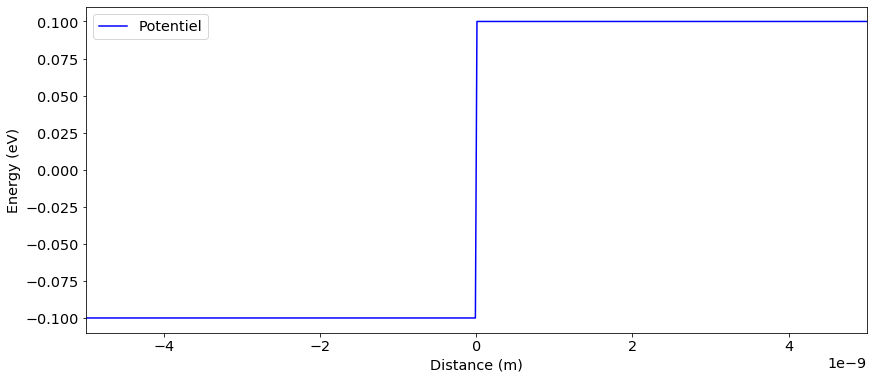

In [43]:
# B) Définition du potentiel ####################################################################################

#% 1. Choix du potentiel
print('Choix du potentiel')
print(' 1. Plat (= puits infini) -- default choice')
print(' 2. Marche')
print(' 3. Puits fini centré sur x = 0')
print(' 4. Harmonique')
print(' 5. Barrière centrée sur x = 0')
print(' 6. Sinus')

idxPot = 1
idxPot = int(input("Entrez un nombre de 1 à 6: ")) 

# definition du potentiel
if idxPot==2:
    print(' 2. Marche')
    PotMAX = float(input('Hauteur de la marche (eV) = '))
    PotMAX = PotMAX*q
    Pot1 = [-PotMAX/2] * int((xNum-1)/2)
    Pot2 = [PotMAX/2] * int((xNum-1)/2)
    Pot = Pot1 + Pot2
elif idxPot==3:
    print(' 3. Puits fini centré sur x = 0')
    PotMAX = float(input('Profondeur du puits (eV) = '))
    #PotMAX = PotMAX*q
    Width = float(input('Largeur du puits (en nm, max: 10 nm)= '))
    Width = Width*1e-9
    Pot = []
    for ii, xx in enumerate(xArr):
        if (xx <= - Width/2) or (xx >= Width/2):
            Pot.append(PotMAX)
        else:
            Pot.append(0.0)
elif idxPot==4:
    print(' 4. Harmonique')
    K = float(input(' "Raideur" du potentiel harmonique (N/m) = '))
    Pot = 0.52*K*numpy.square(xArr)
    print('! PotMAX redéfini automatiquement !')     
    PotMAX = numpy.max(Pot)
elif idxPot==5:
    print(' 5. Barrière centrée sur x = 0')
    PotMAX = float(input('Hauteur de la barrière (eV) = '))
    PotMAX = PotMAX*q
    Width = float(input('Largeur du puits (en nm, max: 10 nm)= '))
    Width = Width*1e-9
    Pot = []
    for ii, xx in enumerate(xArr):
        if (xx <= - Width/2) or (xx >= Width/2):
            Pot.append(0.0)
        else:
            Pot.append(PotMAX)
elif idxPot==6:
    print(' 6. Sinus')
    n = 10 # nombre de périodes (défaut : 10)
    n = float(input('Nombre de périodes ? : '))
    offset = 0.25 # décalage exprimé en périodes (défaut : 0.25)
    PotMAX = float(input('Hauteur de la barrière (eV) = '))
    PotMAX = PotMAX*q
    Pot = PotMAX * numpy.sin(n * (xArr-xMIN) * (2*math.pi)/(xMAX-xMIN) - offset*(2*math.pi))
else: 
    print(' 1. Plat (= puits infini) -- default choice')
    PotMAX = 0.3*q
    Pot = [0.0] * int(xNum-1)

    
# affichage du potentiel
plt.plot(xArr,numpy.array(Pot)/q,label='Potentiel', color='b')
plt.legend(fontsize='x-large')
plt.yticks(color='k', size='x-large')
plt.xticks(color='k', size='x-large') 
plt.ylabel('Energy (eV)',fontsize='x-large')
plt.xlabel('Distance (m)',fontsize='x-large')
plt.xlim((xMIN,xMAX))
plt.show()


In [44]:
# C) Calcul des niveaux énergétiques et des fonctions d'ondes par différences finies 
# 1. Définition des matrices A et B
diag2 = [1.0] * int(xNum-2)
diag3 = [1.0] * int(xNum-3)

# Energie cinétique A
matDiff = -2*numpy.diag(diag2,k=0) + numpy.diag(diag3,k=1) + numpy.diag(diag3,k=-1)
# 
matKin = -(hb**2)/(2*m) * matDiff/(dx**2)

# Energie potentiel B
matPot  = numpy.diag(Pot[1:int(xNum-1)],k=0)

# 2. Hamiltonien de l'equation de Schroedinger H = (a A + B ) with a = -(hb**2)/(2* m * dx**2) 
H = matKin + matPot

# 3. Résolution de l'équation aux valeurs propres H Psi = E Psi Psi[:,i]`` 
#is the normalized eigenvector corresponding to the eigenvalue ``E[i]``.
E, Psi = numpy.linalg.eig(H)

# Tri en ordre croissant des valeurs propres et des vecteurs d'ondes correspondants
E_sorted = numpy.sort(E)
sorted_Psi = Psi[:,numpy.argsort(E)]


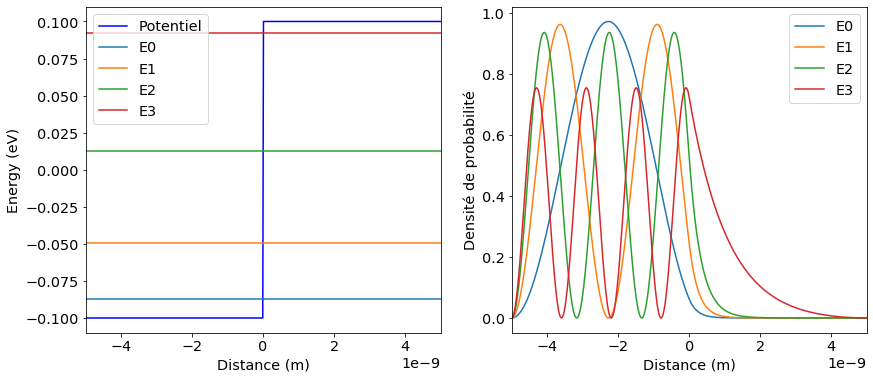

In [45]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (14, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Affichage des premiers niveaux energétiques

plt.subplot(1,2,1)

plt.plot(xArr,numpy.array(Pot)/q,label='Potentiel', color='b')
for ii in vectEn:
    plt.plot(xArr,[E_sorted[ii]/q]*len(xArr),label='E' + str(ii))
   
plt.legend(fontsize='x-large')
plt.yticks(color='k', size='x-large')
plt.xticks(color='k', size='x-large') 
plt.ylabel('Energy (eV)',fontsize='x-large')
plt.xlabel('Distance (m)',fontsize='x-large')
plt.xlim((xMIN,xMAX))
#plt.show()


# Affichage des fonctions d'ondes

plt.subplot(1,2,2)

# ajouter Phi_0 and Phi_n = 0
Psi_new = numpy.insert(sorted_Psi,0,0,axis=1)
Psi_new = numpy.insert(Psi_new,xNum-1,0,axis=1)
# norme au carré de Psi 
PSI2 = numpy.conj(Psi_new)*Psi_new
PSIMAX = numpy.max(PSI2)

for ii in vectPSIn:
    plt.plot(xArr[1:None],PSI2[:,ii+1]/PSIMAX,label='E' + str(ii))

plt.legend(fontsize='x-large',bbox_to_anchor=(1.0, 1.0))
plt.yticks(color='k', size='x-large')
plt.xticks(color='k', size='x-large') 
plt.ylabel('Densité de probabilité',fontsize='x-large')
plt.xlabel('Distance (m)',fontsize='x-large')
plt.xlim((xMIN,xMAX))
plt.show()
